# MDI+: Example Usages

In [27]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [28]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [29]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [30]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)

In [31]:
# make predictions with RF+
preds = rf_plus_model.predict(X_test)
r2_score(y_test, preds)

0.34698224500174446

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [32]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "inside")

intercept: [-0.10398503 -0.08172123 -0.09945402 -0.07792567 -0.08166928 -0.07777436
 -0.0940921  -0.08866097 -0.08734968 -0.09183644 -0.07685937 -0.10141223
 -0.09734803 -0.09387226 -0.09385401 -0.09530155 -0.09776029 -0.08362297
 -0.08942538 -0.10061592 -0.07678825 -0.10704222 -0.09155126 -0.09886119
 -0.08569971 -0.0925236  -0.0760316  -0.0819787  -0.09006348 -0.10485501
 -0.08326487 -0.09918595 -0.10336657 -0.08752871 -0.10582165 -0.08040115
 -0.09627016 -0.09785763 -0.08985843 -0.10022212 -0.09327382 -0.08387003
 -0.1065312  -0.09204332 -0.07231534 -0.07296246 -0.09700819 -0.09395323
 -0.09337129 -0.08910026 -0.1052652  -0.08825781 -0.10270825 -0.07751676
 -0.10404367 -0.10227149 -0.09943638 -0.08718035 -0.07708508 -0.07345991
 -0.10081936 -0.09955069 -0.08714053 -0.10072587 -0.10912988 -0.10147501
 -0.09470437 -0.07373074 -0.09972679 -0.07036565 -0.08454935 -0.10745463
 -0.10187305 -0.09185588 -0.09734828 -0.10267336 -0.08852948 -0.10035234
 -0.09106913 -0.09314905 -0.08073135 -0.

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.672631  0.358234  0.028880  0.057701  0.015575  0.056442  0.040418   
1    0.460512  0.363130  0.023863  0.057306  0.045231  0.084329  0.036492   
2    0.454935  0.375974  0.029303  0.082377  0.081418  0.080423  0.045267   
3    0.392357  0.769763  0.020639  0.056750  0.044741  0.034288  0.034914   
4    0.394973  0.782237  0.024475  0.050768  0.036583  0.026376  0.048031   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.644839  0.379106  0.057949  0.056403  0.019269  0.056806  0.043497   
130  0.400796  0.528184  0.035797  0.055646  0.042349  0.064912  0.027388   
131  0.657520  0.440600  0.041764  0.098697  0.023098  0.046291  0.025364   
132  0.568607  0.340902  0.024608  0.052334  0.016276  0.055052  0.035352   
133  0.555118  0.515994  0.028606  0.072153  0.034

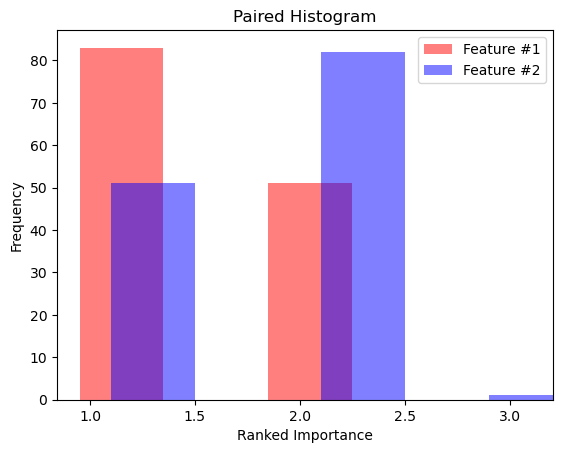

In [33]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [34]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "outside")

intercept: [-0.10398503 -0.08172123 -0.09945402 -0.07792567 -0.08166928 -0.07777436
 -0.0940921  -0.08866097 -0.08734968 -0.09183644 -0.07685937 -0.10141223
 -0.09734803 -0.09387226 -0.09385401 -0.09530155 -0.09776029 -0.08362297
 -0.08942538 -0.10061592 -0.07678825 -0.10704222 -0.09155126 -0.09886119
 -0.08569971 -0.0925236  -0.0760316  -0.0819787  -0.09006348 -0.10485501
 -0.08326487 -0.09918595 -0.10336657 -0.08752871 -0.10582165 -0.08040115
 -0.09627016 -0.09785763 -0.08985843 -0.10022212 -0.09327382 -0.08387003
 -0.1065312  -0.09204332 -0.07231534 -0.07296246 -0.09700819 -0.09395323
 -0.09337129 -0.08910026 -0.1052652  -0.08825781 -0.10270825 -0.07751676
 -0.10404367 -0.10227149 -0.09943638 -0.08718035 -0.07708508 -0.07345991
 -0.10081936 -0.09955069 -0.08714053 -0.10072587 -0.10912988 -0.10147501
 -0.09470437 -0.07373074 -0.09972679 -0.07036565 -0.08454935 -0.10745463
 -0.10187305 -0.09185588 -0.09734828 -0.10267336 -0.08852948 -0.10035234
 -0.09106913 -0.09314905 -0.08073135 -0.

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.642764  0.248764  0.028513  0.049907  0.012972  0.052176  0.037951   
1    0.315352  0.279106  0.022912  0.048905  0.042857  0.072796  0.034245   
2    0.378210  0.265114  0.024944  0.073004  0.073343  0.069957  0.042318   
3    0.288014  0.726761  0.020174  0.051881  0.039079  0.032389  0.026832   
4    0.298420  0.737991  0.023763  0.043795  0.033226  0.024809  0.044509   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.602326  0.311885  0.051779  0.049506  0.017188  0.054886  0.040630   
130  0.287700  0.514417  0.034870  0.047490  0.035724  0.060318  0.025625   
131  0.631009  0.315654  0.040697  0.087986  0.021174  0.042123  0.023796   
132  0.531868  0.243455  0.024323  0.046889  0.014043  0.051494  0.032943   
133  0.516449  0.361172  0.026299  0.061399  0.028

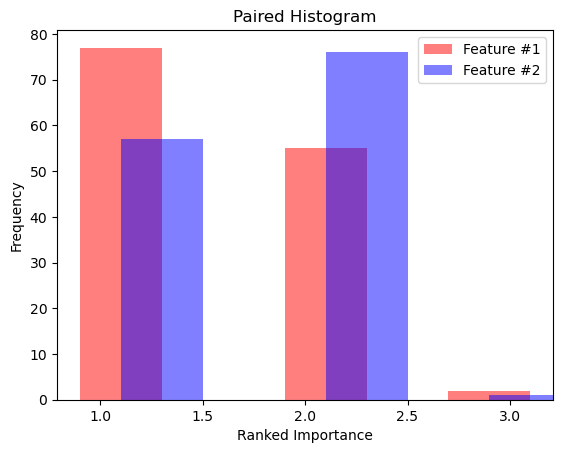

In [35]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}$

In [36]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "none")

intercept: [-0.10398503 -0.08172123 -0.09945402 -0.07792567 -0.08166928 -0.07777436
 -0.0940921  -0.08866097 -0.08734968 -0.09183644 -0.07685937 -0.10141223
 -0.09734803 -0.09387226 -0.09385401 -0.09530155 -0.09776029 -0.08362297
 -0.08942538 -0.10061592 -0.07678825 -0.10704222 -0.09155126 -0.09886119
 -0.08569971 -0.0925236  -0.0760316  -0.0819787  -0.09006348 -0.10485501
 -0.08326487 -0.09918595 -0.10336657 -0.08752871 -0.10582165 -0.08040115
 -0.09627016 -0.09785763 -0.08985843 -0.10022212 -0.09327382 -0.08387003
 -0.1065312  -0.09204332 -0.07231534 -0.07296246 -0.09700819 -0.09395323
 -0.09337129 -0.08910026 -0.1052652  -0.08825781 -0.10270825 -0.07751676
 -0.10404367 -0.10227149 -0.09943638 -0.08718035 -0.07708508 -0.07345991
 -0.10081936 -0.09955069 -0.08714053 -0.10072587 -0.10912988 -0.10147501
 -0.09470437 -0.07373074 -0.09972679 -0.07036565 -0.08454935 -0.10745463
 -0.10187305 -0.09185588 -0.09734828 -0.10267336 -0.08852948 -0.10035234
 -0.09106913 -0.09314905 -0.08073135 -0.

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0   -0.636515  0.186718 -0.011671  0.018044  0.006754 -0.008908  0.004001   
1   -0.255329  0.230635 -0.005375  0.022413 -0.016771 -0.058070 -0.009657   
2    0.350939  0.157078 -0.000919  0.011747 -0.044978 -0.044815 -0.030385   
3   -0.119110 -0.720638 -0.001323  0.020365  0.008272  0.007538 -0.003081   
4   -0.208253 -0.722256  0.010377 -0.011455 -0.010089  0.006980 -0.005915   
..        ...       ...       ...       ...       ...       ...       ...   
129 -0.594030  0.292284  0.037091  0.029102  0.002290 -0.010351 -0.011684   
130 -0.077038  0.511952 -0.005654  0.033089 -0.017612  0.042926  0.014470   
131 -0.619549 -0.128365  0.000849 -0.034637  0.001794  0.017829  0.004776   
132 -0.514859  0.135375 -0.005458  0.022667  0.006775 -0.012804  0.001726   
133  0.510728 -0.123171 -0.001347  0.050592  0.018

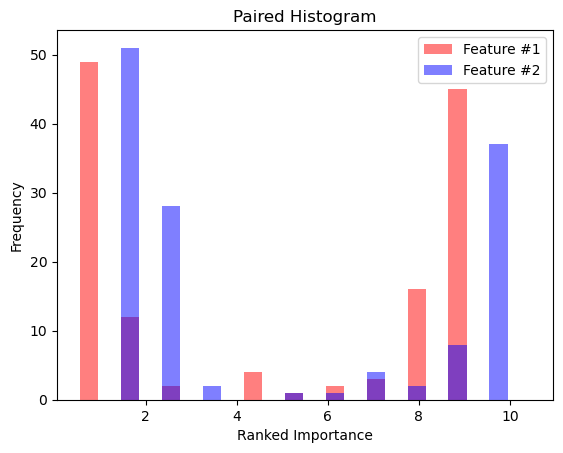

In [37]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()